In [24]:
import torch
from torch.utils.data import DataLoader
from utils import make_regression_data, mse, log_epoch, RegressionDataset
import matplotlib.pyplot as plt

class LinearRegressionManual:
    def __init__(self, in_features):
        self.w = torch.randn(in_features, 1, dtype=torch.float32, requires_grad=False)
        self.b = torch.zeros(1, dtype=torch.float32, requires_grad=False)

    def __call__(self, X):
        return X @ self.w + self.b

    def parameters(self):
        return [self.w, self.b]

    def zero_grad(self):
        self.dw = torch.zeros_like(self.w)
        self.db = torch.zeros_like(self.b)
    

    def l1_regularization(self):
        """L1-регуляризация (Lasso): возвращает сумму |w|"""
        return torch.sum(torch.abs(self.w))

    def l2_regularization(self):
        """L2-регуляризация (Ridge): возвращает сумму w^2"""
        return torch.sum(self.w ** 2)

    def backward(self, X, y, y_pred):
        n = X.shape[0]
        error = y_pred - y
        self.dw = (X.T @ error) / n
        self.db = error.mean(0)

        if self.l1_lambda > 0:
            self.dw += self.l1_lambda * torch.sign(self.w)  # Производная |w| = sign(w)
        if self.l2_lambda > 0:
            self.dw += 2 * self.l2_lambda * self.w         # Производная w^2 = 2w
        
        

    def step(self, lr):
        self.w -= lr * self.dw
        self.b -= lr * self.db

    def set_l1_lambda(self, lambda_):
        """Установка коэффициента L1-регуляризации"""
        self.l1_lambda = lambda_

    def set_l2_lambda(self, lambda_):
        """Установка коэффициента L2-регуляризации"""
        self.l2_lambda = lambda_

    def save(self, path):
        torch.save({'w': self.w, 'b': self.b}, path)

    def load(self, path):
        state = torch.load(path)
        self.w = state['w']
        self.b = state['b']


Размер датасета: 200
Количество батчей: 7
Пример данных: (tensor([0.6165]), tensor([0.1625]))
Epoch 10: loss=0.1917
Epoch 20: loss=0.0963
Epoch 30: loss=0.0617
Epoch 40: loss=0.0429
Epoch 50: loss=0.0386
Epoch 60: loss=0.0355
Epoch 70: loss=0.0355
Epoch 80: loss=0.0338
80 tensor(0.0339)
----------------------------------------------------------------
Epoch 10: loss=0.1728
Epoch 20: loss=0.1452
Epoch 30: loss=0.1415
Epoch 40: loss=0.1257
Epoch 50: loss=0.1199
Epoch 60: loss=0.1076
Epoch 70: loss=0.0966
Epoch 80: loss=0.0926
Epoch 90: loss=0.0880
Epoch 100: loss=0.0822
Epoch 10: loss=1.5973
Epoch 20: loss=1.4766
Epoch 30: loss=1.2495
Epoch 40: loss=1.1661
Epoch 50: loss=1.1707
Epoch 60: loss=1.0608
Epoch 70: loss=1.0327
73 tensor(0.9990)
----------------------------------------------------------------


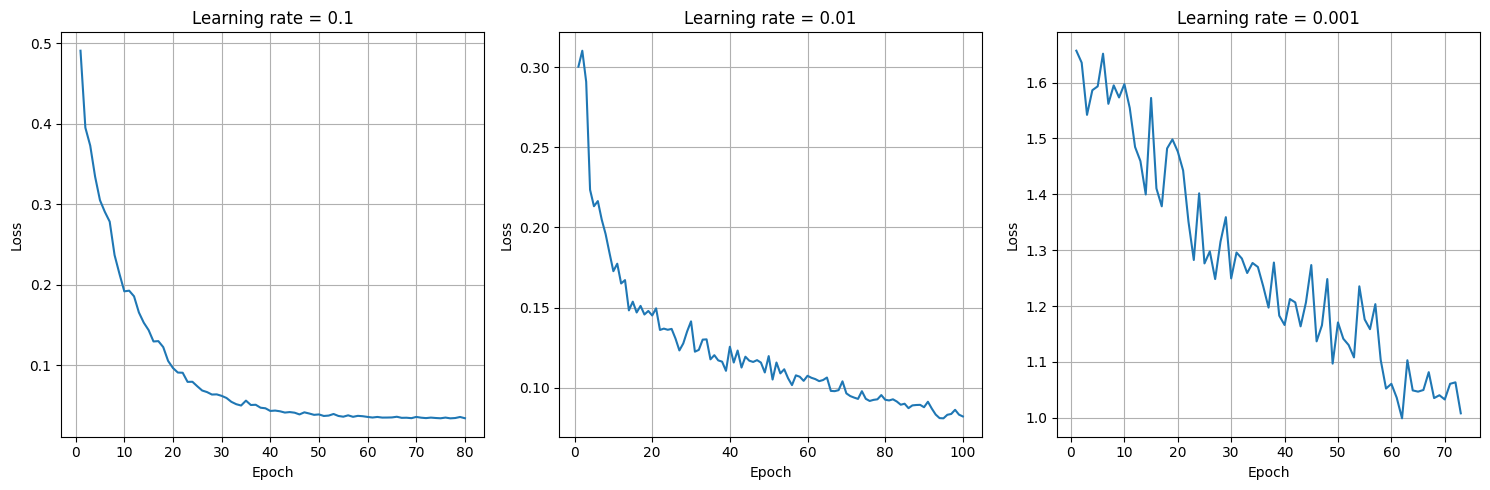

In [27]:
import matplotlib.pyplot as plt  # Правильный импорт

if __name__ == '__main__':
    # Генерируем данные
    X, y = make_regression_data(n=200)
    
    # Создаём датасет и даталоадер
    dataset = RegressionDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    print(f'Размер датасета: {len(dataset)}')
    print(f'Количество батчей: {len(dataloader)}')
    print(f'Пример данных: {dataset[0]}')
    
    # Обучаем модель
    lr_list = [0.1, 0.01, 0.001]
    
    # Создаем фигуру для графиков
    plt.figure(figsize=(15, 5))
    
    for idx, lr in enumerate(lr_list):
        model = LinearRegressionManual(in_features=1)
        model.set_l1_lambda(0.01)  # Включить L1 с lambda=0.01
        model.set_l2_lambda(0.001)  # Включить L2 с lambda=0.001
        epochs = 100
        best_loss = float("inf")
        waiting_Epoch = 10
        no_improve = 0
        
        # Для хранения истории потерь
        loss_history = []
        
        for epoch in range(1, epochs + 1):
            total_loss = 0
            
            for i, (batch_X, batch_y) in enumerate(dataloader):
                y_pred = model(batch_X)
                loss = mse(y_pred, batch_y)
                total_loss += loss + model.l1_lambda * model.l1_regularization()
                total_loss += model.l2_lambda * model.l2_regularization()
                
                model.zero_grad()
                model.backward(batch_X, batch_y, y_pred)
                model.step(lr)
            
            avg_loss = total_loss / (i + 1)
            loss_history.append(avg_loss)
            
            if epoch % 10 == 0:
                log_epoch(epoch, avg_loss)
            
            if (best_loss - avg_loss) > 0.0005:
                best_loss = avg_loss
                no_improve = 0
            else:
                no_improve += 1
                if waiting_Epoch < no_improve:
                    print(epoch, best_loss)
                    print("-" * 64)
                    break
        
        # Добавляем график для текущего lr
        plt.subplot(1, len(lr_list), idx + 1)  # Исправлена опечатка в subplot
        plt.plot(range(1, len(loss_history) + 1), loss_history)  # Исправлен range
        plt.title(f'Learning rate = {lr}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
    
    # Показываем все графики
    plt.tight_layout()
    plt.show()
            
        
        

видим, что в нашем случае оптимальный параметр 0.1, чем меньше lr , тем больше потерь

Размер датасета: 200
Пример данных: (tensor([0.4000]), tensor([-0.2681]))

batch_size = 128
Количество батчей: 2
Epoch 10: loss=0.5270
Epoch 20: loss=0.4151
Epoch 30: loss=0.3132
Epoch 40: loss=0.2415
Epoch 50: loss=0.1938
Epoch 60: loss=0.1575
Epoch 70: loss=0.1254
Epoch 80: loss=0.1053
Epoch 90: loss=0.0848
Epoch 100: loss=0.0785


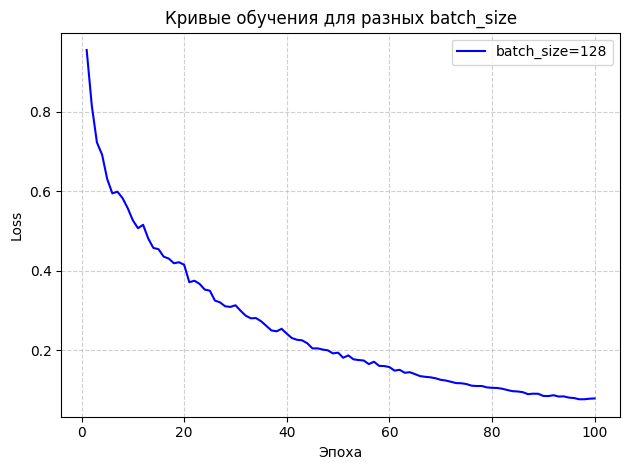


batch_size = 256
Количество батчей: 1
Epoch 10: loss=1.1141
Epoch 20: loss=0.8794
Epoch 30: loss=0.7558
Epoch 40: loss=0.6539
Epoch 50: loss=0.5659
Epoch 60: loss=0.4895
Epoch 70: loss=0.4232
Epoch 80: loss=0.3658
Epoch 90: loss=0.3213
Epoch 100: loss=0.2848


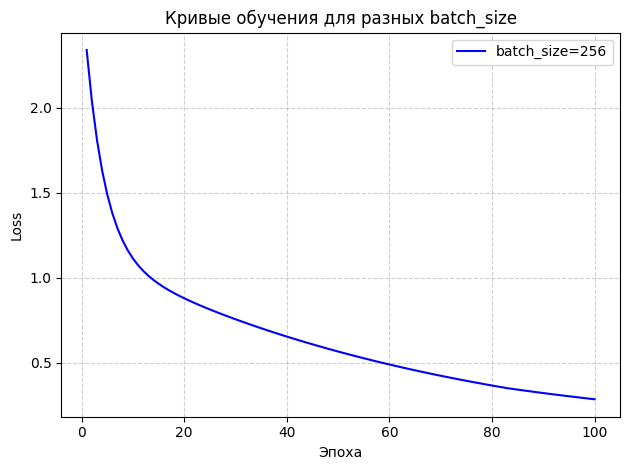


batch_size = 512
Количество батчей: 1
Epoch 10: loss=0.1254
Epoch 20: loss=0.0461
Epoch 30: loss=0.0400
Epoch 40: loss=0.0390
Ранняя остановка на эпохе 44, лучший loss: 0.03958
----------------------------------------------------------------


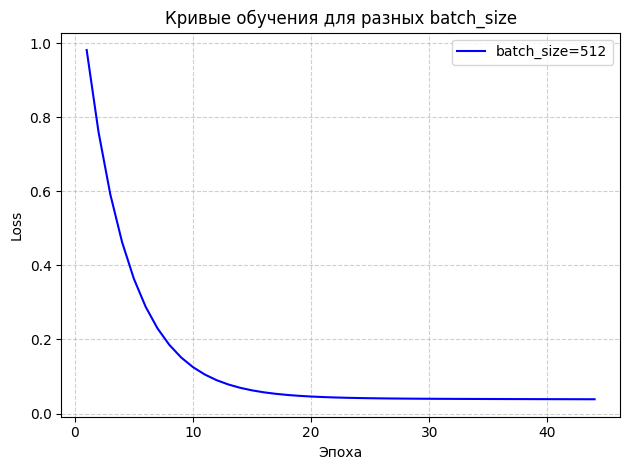

Обучение завершено. Лучший loss: 0.03958


In [36]:
if __name__ == '__main__':
    # Генерируем данные
    X, y = make_regression_data(n=200)
    
    # Создаём датасет
    dataset = RegressionDataset(X, y)
    print(f'Размер датасета: {len(dataset)}')
    print(f'Пример данных: {dataset[0]}')
    
    batches = [128, 256, 512]
    for batch_size in batches:
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        print(f'\nbatch_size = {batch_size}')
        print(f'Количество батчей: {len(dataloader)}')
        
        # Обучаем модель
        lr = 0.1
        model = LinearRegressionManual(in_features=1)
        model.set_l1_lambda(0.01)
        model.set_l2_lambda(0.001)
        
        epochs = 100
        best_loss = float("inf")
        waiting_Epoch = 10
        no_improve = 0
        loss_history = []
        
        for epoch in range(1, epochs + 1):
            total_loss = 0
            for i, (batch_X, batch_y) in enumerate(dataloader):
                y_pred = model(batch_X)
                loss = mse(y_pred, batch_y)
                total_loss += loss + model.l1_lambda * model.l1_regularization()
                total_loss += model.l2_lambda * model.l2_regularization()
                
                model.zero_grad()
                model.backward(batch_X, batch_y, y_pred)
                model.step(lr)
            
            avg_loss = total_loss / (i + 1)
            loss_history.append(avg_loss)
            
            if epoch % 10 == 0:
                log_epoch(epoch, avg_loss)
            
            if (best_loss - avg_loss) > 0.001:
                best_loss = avg_loss
                no_improve = 0
            else:
                no_improve += 1
                if waiting_Epoch < no_improve:
                    print(f'Ранняя остановка на эпохе {epoch}, лучший loss: {best_loss:.5f}')
                    print("-" * 64)
                    break
        
        plt.plot(range(1, len(loss_history) + 1), 
                loss_history, 
                color='blue',
                label=f'batch_size={batch_size}')
        plt.title('Кривые обучения для разных batch_size')
        plt.xlabel('Эпоха')
        plt.ylabel('Loss')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    print(f'Обучение завершено. Лучший loss: {best_loss:.5f}')

тут мы увеличли batch_size из за большего объема наша регрессия стала работать хуже

Размер датасета: 200
Количество батчей: 7
Epoch 10, Loss: 0.2189
Epoch 20, Loss: 0.1127
Epoch 30, Loss: 0.0655
Epoch 40, Loss: 0.0462
Epoch 50, Loss: 0.0414
Epoch 60, Loss: 0.0353
Epoch 70, Loss: 0.0342
Epoch 80, Loss: 0.0325
Early stopping at epoch 83, Best Loss: 0.0329


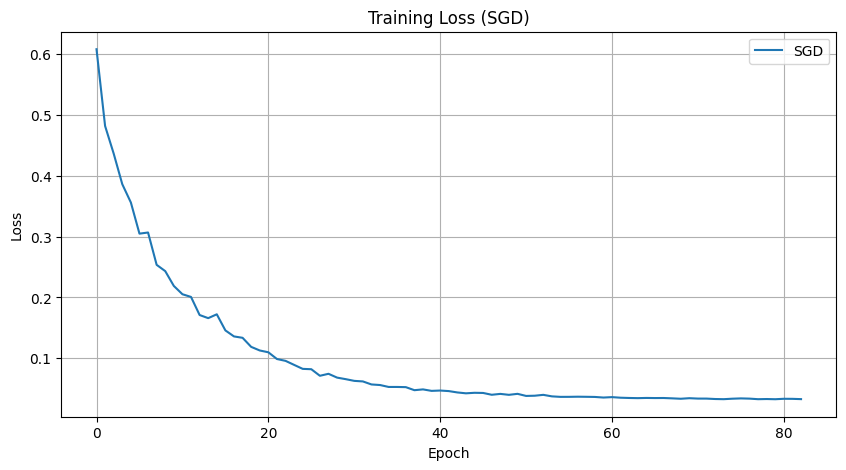

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

if __name__ == '__main__':
    # Генерируем данные
    X, y = make_regression_data(n=200)
    
    # Создаём датасет и даталоадер
    dataset = RegressionDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    print(f'Размер датасета: {len(dataset)}')
    print(f'Количество батчей: {len(dataloader)}')
    
    # Инициализация модели
    model = LinearRegressionManual(in_features=1)
    model.set_l1_lambda(0.01)
    model.set_l2_lambda(0.001)
    
    # Параметры SGD
    lr = 0.1
    epochs = 100
    
    # Для визуализации
    loss_history = []
    best_loss = float('inf')
    no_improve = 0
    
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        
        for batch_X, batch_y in dataloader:
            y_pred = model(batch_X)
            loss = mse(y_pred, batch_y) 
            loss += model.l1_lambda * model.l1_regularization()
            loss += model.l2_lambda * model.l2_regularization()
            
            # Backward pass
            model.zero_grad()
            model.backward(batch_X, batch_y, y_pred)
            
            # Чистый SGD (без momentum)
            # Предполагаем, что model.step() делает простое обновление:
            # weight -= lr * weight_grad
            # bias -= lr * bias_grad
            model.step(lr)
            
            epoch_loss += loss.item()
        
        # Средний loss за эпоху
        avg_loss = epoch_loss / len(dataloader)
        loss_history.append(avg_loss)
        
        # Логирование
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {avg_loss:.4f}')
        
        # Ранняя остановка
        if avg_loss < best_loss - 0.001:
            best_loss = avg_loss
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= 10:
                print(f'Early stopping at epoch {epoch}, Best Loss: {best_loss:.4f}')
                break
    
    # Визуализация
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label='SGD')
    plt.title('Training Loss (SGD)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Сохранение модели
    